In [1]:
!pip install --upgrade category_encoders matplotlib pandas_profiling seaborn psutil xlrd eli5 pdp pdpbox
import sys, getpass, pandas_profiling
a = getpass.getuser()
### examples appending of folder
# A
sys.path.append('/home/{}/Code/Github-Repos/BFDS_Library/'.format(a))
# B
#sys.path.append('/Users/{}/Programs/BFDS_Library/'.format(a))

# Pull in library if in Google Colab
if 'google.colab' in sys.modules:
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/jeibloo/BFDS_Library.git
    !git pull origin master

#from BFDS_Library import ACompass, BWarp, CToolbox 
import AMap as am
import BCook as bc
import CTools as ct

Requirement already up-to-date: category_encoders in /home/ygeun/.local/share/virtualenvs/coral-death-Jt6ndagv/lib/python3.7/site-packages (2.0.0)
Requirement already up-to-date: matplotlib in /home/ygeun/.local/share/virtualenvs/coral-death-Jt6ndagv/lib/python3.7/site-packages (3.1.1)
Requirement already up-to-date: pandas_profiling in /home/ygeun/.local/share/virtualenvs/coral-death-Jt6ndagv/lib/python3.7/site-packages (2.3.0)
Requirement already up-to-date: seaborn in /home/ygeun/.local/share/virtualenvs/coral-death-Jt6ndagv/lib/python3.7/site-packages (0.9.0)
Requirement already up-to-date: psutil in /home/ygeun/.local/share/virtualenvs/coral-death-Jt6ndagv/lib/python3.7/site-packages (5.6.3)
Requirement already up-to-date: xlrd in /home/ygeun/.local/share/virtualenvs/coral-death-Jt6ndagv/lib/python3.7/site-packages (1.2.0)
Requirement already up-to-date: eli5 in /home/ygeun/.local/share/virtualenvs/coral-death-Jt6ndagv/lib/python3.7/site-packages (0.10.0)
Requirement already up-to

Cool dataset from [Reefbase](http://www.reefbase.org/gis_maps/useofmaps.aspx).

In [101]:
import pandas as pd
pd.options.display.float_format = None
df = pd.read_excel('./dataset/CoralBleaching.xlsm')

In [102]:
target = 'BLEACHING_SEVERITY'

In [103]:
def wgle(df):
    # Group by bleaching or not
    df[target] = df[target].replace({
        'Low':2, 'HIGH':4, 'Medium':3, 'Severity Unknown':1,
        'No Bleaching':0})

    # Get all features for ease-of-use
    features, num_feats, cat_feats = bc.pantryFeatures(df)
    
    # Drop columns with almost no values.
    df = bc.diceUglyCols(df, features, percent=50)
    
    # Special weird values
    df['LAT'] = df['LAT'].replace({-10269:-10.269})
    
    return df

In [5]:
df.profile_report()

In [104]:
dfw = wgle(df)
dfw = ct.downcastDataFrame(dfw)

Mem. usage decreased to  0.37 Mb (40.4% reduction)


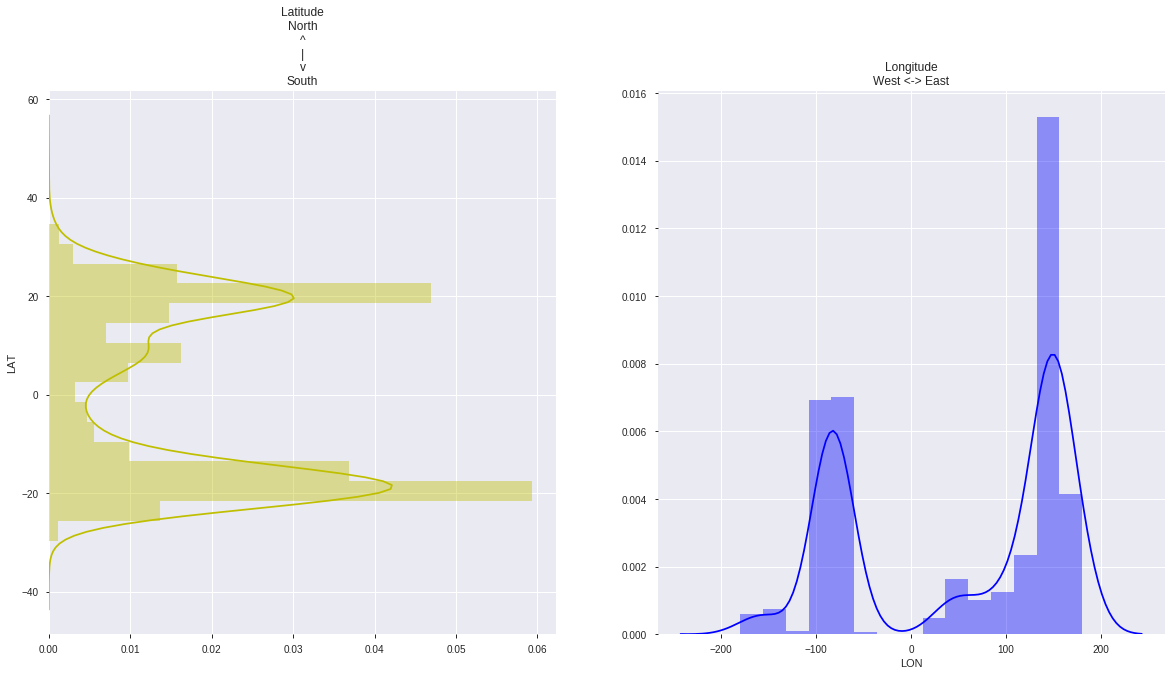

In [16]:
### Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(20,10))
ax1.title.set_text('Latitude\nNorth\n^\n|\nv\nSouth')
ax2.title.set_text('Longitude\nWest <-> East')
sns.distplot(df_wrangle['LAT'], ax=ax1, color='y',vertical=True)
sns.distplot(df_wrangle['LON'], ax=ax2, color='b',vertical=False)

In [17]:
dfw.head(3)

ID REGION SUBREGION COUNTRY               LOCATION    LAT    LON  MONTH  \
0  7067    NaN       NaN  France     Hermitage, Reunion -21.22  55.22    4.0   
1  7068    NaN       NaN  France  Saint Gilles, Reunion -21.05  55.23    7.0   
2  7069    NaN       NaN  France     Saint-Leu, Reunion -21.16  55.28    2.0   

   YEAR  SEVERITY_CODE  BLEACHING_SEVERITY  \
0  2008              0                   0   
1  2008              0                   0   
2  2008              0                   0   

                                              SOURCE COUNTRY_CODE  
0  Reef Check, Submitted by Harold Cambert. Site ...          FRA  
1  Reef Check, Submitted by Harold Cambert. Site ...          FRA  
2  Reef Check, Submitted by Harold Cambert . Site...          FRA

In [106]:
import numpy as np
### Export wrangled dataframe
dfw.sort_values(by="YEAR",inplace=True)
### Group into decades
df_chunked = dfw.copy()
'''
df_chunked = df_chunked.mask(
    (df_chunked['YEAR'] <= 1969, '60s'),
    (((df_chunked['YEAR'] <= 1979) & (df_chunked['YEAR'] >= 1970)),'70s'),
    (((df_chunked['YEAR'] <= 1989) & (df_chunked['YEAR'] >= 1980)),'80s'),
    (((df_chunked['YEAR'] <= 1999) & (df_chunked['YEAR'] >= 1990)),'90s'),
    (((df_chunked['YEAR'] <= 2012) & (df_chunked['YEAR'] >= 2000)),'00s')
)
'''
df_chunked['YEAR'] = np.where(df_chunked['YEAR'].between(1960,1969),60,df_chunked['YEAR'])
df_chunked['YEAR'] = np.where(df_chunked['YEAR'].between(1970,1979),70,df_chunked['YEAR'])
df_chunked['YEAR'] = np.where(df_chunked['YEAR'].between(1980,1989),80,df_chunked['YEAR'])
df_chunked['YEAR'] = np.where(df_chunked['YEAR'].between(1990,1999),90,df_chunked['YEAR'])
df_chunked['YEAR'] = np.where(df_chunked['YEAR'].between(2000,2012),2000,df_chunked['YEAR'])
df_chunked['YEAR'] = df_chunked['YEAR'].replace({60:'1960s',70:'1970s',80:'1980s',
                                                 90:'1990s',2000:'2000s'})
df_chunked.head()
df_chunked.to_csv('./CoralBleachingClean.csv')

In [19]:
print("Cut down {} columns.".format(df.shape[1]-dfw.shape[1]))

Cut down 15 columns.


In [20]:
# Split into Train Test & Val by year
test_mask = (dfw['YEAR'] > 1999)
vali_mask = ((dfw['YEAR'] > 1990) & (df['YEAR'] <= 1999))
trin_mask = (dfw['YEAR'] <= 1990)
# Use masks
test = dfw[test_mask].copy()
trin = dfw[trin_mask].copy()
vali = dfw[vali_mask].copy()

In [21]:
print("ASSURANCE CHECK\nTest shape:{}\nTrain shape:{}\nValidation shape:{}".format(
    test.shape,trin.shape,vali.shape)
)

ASSURANCE CHECK
Test shape:(3487, 13)
Train shape:(213, 13)
Validation shape:(2490, 13)


In [22]:
print(bc.soupBaseModel(trin, target, 1),
      bc.soupBaseModel(vali, target, 1),
      bc.soupBaseModel(test, target, 1))

Classification
1    0.643192
4    0.187793
2    0.084507
3    0.056338
0    0.028169
Name: BLEACHING_SEVERITY, dtype: float64
Classification
4    0.297189
0    0.286345
2    0.194779
3    0.173896
1    0.047791
Name: BLEACHING_SEVERITY, dtype: float64
Classification
1    0.271007
2    0.265558
0    0.217379
3    0.133639
4    0.112418
Name: BLEACHING_SEVERITY, dtype: float64
None None None


In [23]:
### Chop the sets up
features, _, _ = bc.pantryFeatures(trin)
X_train = trin[features].drop(target,axis=1)
y_train = trin[target]

X_test = test[features].drop(target,axis=1)
y_test = test[target]

X_vali = vali[features].drop(target,axis=1)
y_vali = vali[target]

print("ASSURANCE CHECK\nTrain cols:\t{}\nValidtn cols:\t{}\nTest cols:\t{}".format(
    len(X_train.columns)+1,
    len(X_test.columns)+1,
    len(X_vali.columns)+1)
)

ASSURANCE CHECK
Train cols:	13
Validtn cols:	13
Test cols:	13


In [24]:
# Majority Class Baseline
bc.soupBaseModel(df, target, 1)

Classification
0    0.238611
2    0.230856
1    0.194023
4    0.189338
3    0.147173
Name: BLEACHING_SEVERITY, dtype: float64


In [25]:
df[target].value_counts()

0    1477
2    1429
1    1201
4    1172
3     911
Name: BLEACHING_SEVERITY, dtype: int64

In [26]:
### Start fitting this classification model
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

In [27]:
pipey = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(
        n_estimators=500,
        class_weight='balanced',
        n_jobs=-1,
        random_state=4
    )
)

In [28]:
from sklearn.metrics import accuracy_score
# Train the model on these two beauts
pipey.fit(X_train, y_train);

In [29]:
'''# Preserve the exact pipeline with the exact fit
from joblib import dump
dump(pipey, 'pipey.joblib')''';

In [30]:
X_vali.shape,y_vali.shape

((2490, 12), (2490,))

In [31]:
# Print out what y_val prediction was
#print("Val Set AUC ROC: {}".format(roc_auc_score(y_vali,y_pred_proba)))
print("Val Set score: {}".format(pipey.score(X_vali,y_vali)))

Val Set score: 0.516867469879518


In [32]:
# Test cross-validation
from sklearn.model_selection import cross_val_score
cross_val_score(pipey, X_train, y_train, cv=3, scoring='accuracy')

array([0.93055556, 0.94366197, 0.9       ])

In [33]:
X_combo = pd.concat([X_train, X_vali])
y_combo = pd.concat([y_train, y_vali])
# Train the pipeline on the combo
pipey.fit(X_combo, y_combo)
print("Test Set score: {}".format(pipey.score(X_test,y_test)))

Test Set score: 0.8743905936334958


In [34]:
X_combo.isnull().sum()

ID                 0
LAT                0
LON                0
MONTH            724
YEAR               0
SEVERITY_CODE      0
REGION            15
SUBREGION         15
COUNTRY            0
LOCATION          21
SOURCE             0
COUNTRY_CODE       0
dtype: int64

In [58]:
from pdpbox.pdp import pdp_plot, pdp_isolate
from pdpbox import pdp

enc = ce.OrdinalEncoder()
X_enc = enc.fit_transform(X_combo)
model = RandomForestClassifier(n_estimators=20,random_state=4,n_jobs=-1);

In [59]:
X_enc.drop('MONTH',axis=1,inplace=True)

In [60]:
X_enc = ct.downcastDataFrame(X_enc)

Mem. usage decreased to  0.06 Mb (74.0% reduction)


In [61]:
X_enc.isnull().sum()

ID               0
LAT              0
LON              0
YEAR             0
SEVERITY_CODE    0
REGION           0
SUBREGION        0
COUNTRY          0
LOCATION         0
SOURCE           0
COUNTRY_CODE     0
dtype: int64

In [62]:
model.fit(X_enc,y_combo)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
                       oob_score=False, random_state=4, verbose=0,
                       warm_start=False)

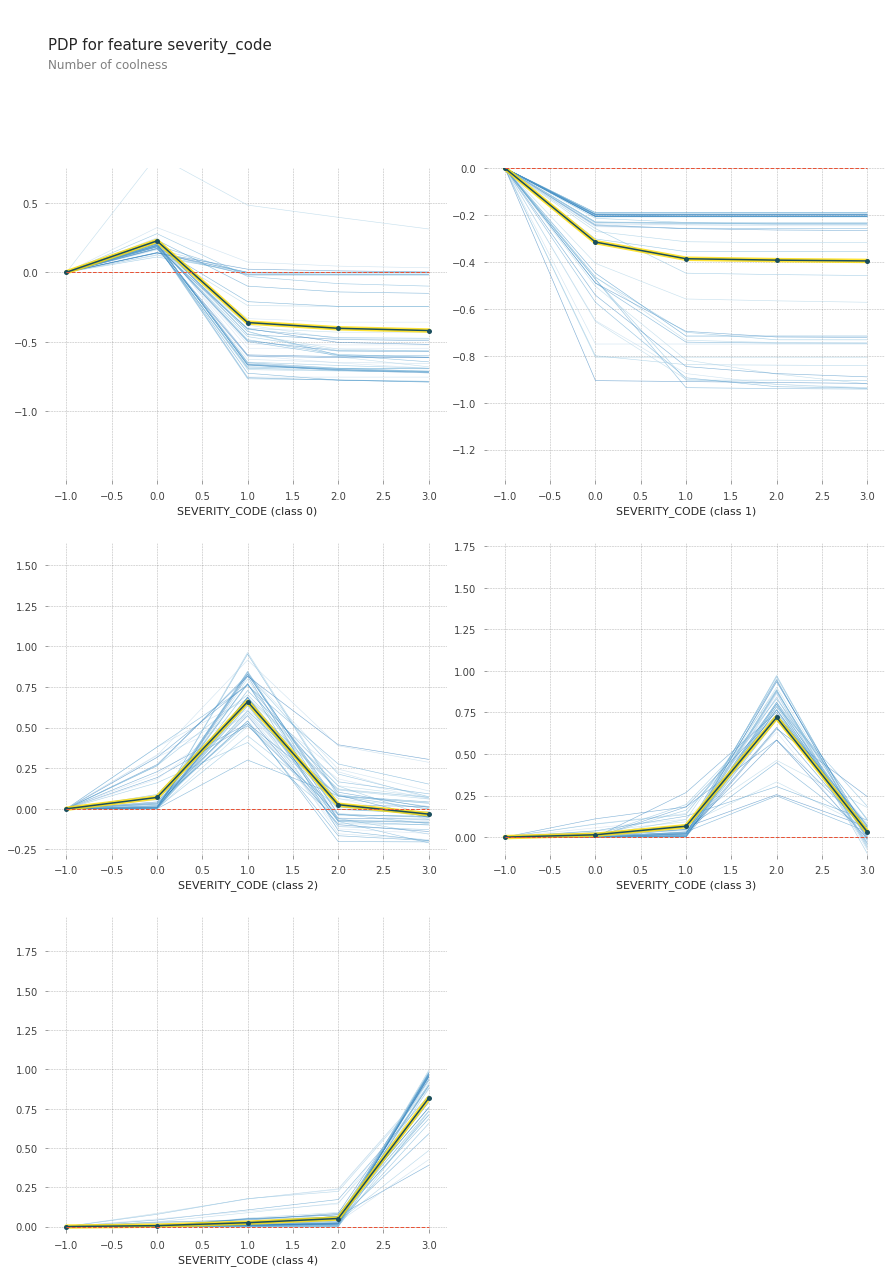

In [94]:
features, _, _ = bc.pantryFeatures(X_combo)
feature = 'SEVERITY_CODE'

pdp_dist = pdp.pdp_isolate(
    model=pipey,
    dataset=X_combo,
    model_features=features,
    feature=feature,
    num_grid_points=100
)
plot_params = {
    # Plot title etc
    'title': 'PDP for feature {}'.format(feature.lower()),
    'subtitle': "Number of coolness",
    'markersize': 5,
    'fill_color': '#af4f4f'
}
fig, axes = pdp_plot(pdp_dist,plot_params=plot_params, feature_name=feature,
         plot_lines=True, frac_to_plot=50)
